In [28]:
import numpy as np
import matplotlib.pyplot as plt
from PyMPDATA import Options, Stepper, Solver, ScalarField, VectorField
from PyMPDATA.boundary_conditions import Periodic

In [29]:
opts = Options(n_iters=2, infinite_gauge=True, nonoscillatory=True)  # 2 iterations for 2nd-order accuracy


Lx = 1000.0       # domain length
Nx = 1000         # number of grid cells
dx = Lx / Nx      # grid spacing
x = np.linspace(0, Lx, Nx, endpoint=False)
c = 1.0           # advection speed
dt = 1.0          # time step size
omega = 2 * np.pi / 400.0  # oscillator frequency

# CORRECTED: Plot every 20 time steps as in original paper
T_plot_max = 660       # Max time for plotting
plot_interval = 20     # Plot every 20 time steps (was 60)

print(f"Grid: {Nx} points, dx={dx}. dt={dt}, c={c}, omega={omega:.4f}")
print(f"Plotting parameters: T_plot_max={T_plot_max}, plot_interval={plot_interval}")

Grid: 1000 points, dx=1.0. dt=1.0, c=1.0, omega=0.0157
Plotting parameters: T_plot_max=660, plot_interval=20


In [30]:
psi0 = np.zeros(Nx)
mask = (x >= 50) & (x <= 150)
psi0[mask] = 0.5 * (1 + np.cos(np.pi * (x[mask] - 100) / 50))
phi0 = np.zeros(Nx)
print(f"Initial psi peak = {psi0.max():.2f} at x ~{x[np.argmax(psi0)]}, phi everywhere = {phi0.min():.1f}")


Initial psi peak = 1.00 at x ~100.0, phi everywhere = 0.0


In [31]:
stepper = Stepper(options=opts, n_dims=1)
halo = stepper.options.n_halo
bc = (Periodic(), Periodic())
psi_field = ScalarField(data=psi0.copy(), halo=halo, boundary_conditions=bc) # Use .copy()
phi_field = ScalarField(data=phi0.copy(), halo=halo, boundary_conditions=bc) # Use .copy()

u = np.full(Nx + 1, c)
u_field = VectorField(data=(u,), halo=halo, boundary_conditions=bc)

# Create Solver instances for psi and phi
# These will be used inside the scheme functions or the main loop
solver_psi = Solver(stepper=stepper, advectee=psi_field, advector=u_field)
solver_phi = Solver(stepper=stepper, advectee=phi_field, advector=u_field)

In [32]:
# The explicit Euler scheme remains for comparison/testing if needed
def run_explicit_euler_scheme(n_steps, psi0_in, phi0_in, current_omega):
    psi_field.get()[:] = psi0_in.copy()
    phi_field.get()[:] = phi0_in.copy()

    # Re-initialize solvers to ensure they use the fresh field data state
    s1 = Solver(stepper=stepper, advectee=psi_field, advector=u_field)
    s2 = Solver(stepper=stepper, advectee=phi_field, advector=u_field)

    for _ in range(n_steps):
        psi_old = psi_field.get().copy()
        phi_old = phi_field.get().copy()

        s1.advance(1) # Advect psi
        s2.advance(1) # Advect phi

        psi_adv = psi_field.get()
        phi_adv = phi_field.get()

        # Oscillator step (Explicit Euler)
        psi_field.get()[:] = psi_adv + dt * current_omega * phi_old
        phi_field.get()[:] = phi_adv - dt * current_omega * psi_old

    psi_ex = psi_field.get().copy()
    phi_ex = phi_field.get().copy()

    return psi_ex, phi_ex

# Trapezoidal scheme according to the paper's equations (17)-(19)
# and their solved form.
def run_trapezoidal_scheme(n_steps, psi0_in, phi0_in, current_omega):
    psi_field.get()[:] = psi0_in.copy()
    phi_field.get()[:] = phi0_in.copy()

    # Re-initialize solvers
    s1 = Solver(stepper=stepper, advectee=psi_field, advector=u_field)
    s2 = Solver(stepper=stepper, advectee=phi_field, advector=u_field)

    for _ in range(n_steps):
        psi_old = psi_field.get().copy()  # psi_i^n
        phi_old = phi_field.get().copy()  # phi_i^n

        # Step 1: Predictor for oscillator term (source terms for MPDATA)
        # psi_half_source is (psi_i^n + 0.5 * dt * current_omega * phi_i^n)
        # phi_half_source is (phi_i^n - 0.5 * dt * current_omega * psi_i^n)
        psi_half_source = psi_old + 0.5 * dt * current_omega * phi_old
        phi_half_source = phi_old - 0.5 * dt * current_omega * psi_old

        psi_field.get()[:] = psi_half_source
        phi_field.get()[:] = phi_half_source

        # Step 2: Advection step (MPDATA)
        s1.advance(1) # Advects psi_half_source to get psi_star
        s2.advance(1) # Advects phi_half_source to get phi_star

        psi_star = psi_field.get().copy() # This is psi_i^* from the paper
        phi_star = phi_field.get().copy() # This is phi_i^*

        # Step 3: Corrector for oscillator term (solution of implicit algebraic equations)
        # psi_i^{n+1} = (psi_i^* + 0.5 * dt * current_omega * phi_i^*) / (1 + (0.5 * dt * current_omega)^2)
        # phi_i^{n+1} = (phi_i^* - 0.5 * dt * current_omega * psi_i^*) / (1 + (0.5 * dt * current_omega)^2)
        coeff = 0.5 * dt * current_omega
        denom = 1.0 + coeff**2

        psi_new = (psi_star + coeff * phi_star) / denom
        phi_new = (phi_star - coeff * psi_star) / denom

        psi_field.get()[:] = psi_new
        phi_field.get()[:] = phi_new

    psi_tr = psi_field.get().copy()
    phi_tr = phi_field.get().copy()

    return psi_tr, phi_tr

<>:50: SyntaxWarning: invalid escape sequence '\p'
<>:51: SyntaxWarning: invalid escape sequence '\p'
<>:50: SyntaxWarning: invalid escape sequence '\p'
<>:51: SyntaxWarning: invalid escape sequence '\p'
C:\Users\User\AppData\Local\Temp\ipykernel_16176\112165262.py:50: SyntaxWarning: invalid escape sequence '\p'
  plt.plot([], 'r-', label='$\psi$', alpha=0.8)  # Empty plot for legend
C:\Users\User\AppData\Local\Temp\ipykernel_16176\112165262.py:51: SyntaxWarning: invalid escape sequence '\p'
  plt.plot([], 'g-', label='$\phi$', alpha=0.8)   # Empty plot for legend


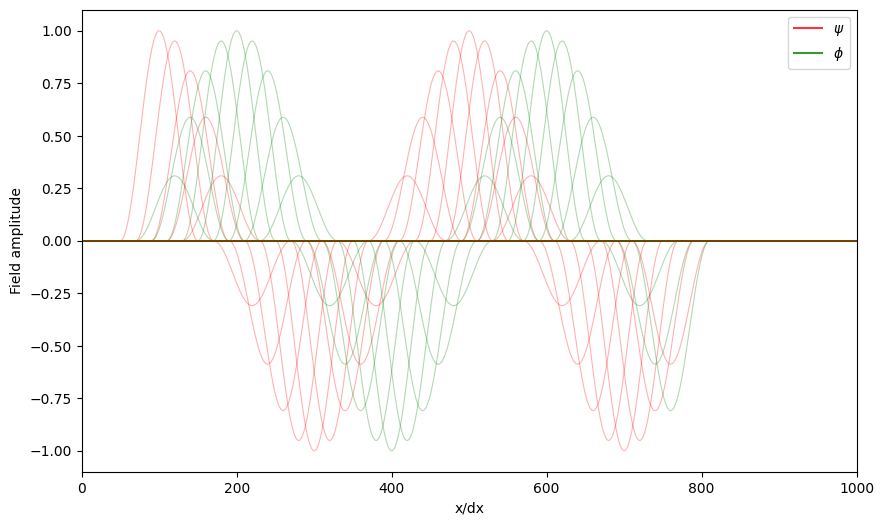

In [33]:
plot_eff_omega = -omega  # Maintain sign convention for correct phase

# Initialize fields
psi_field.get()[:] = psi0.copy()
phi_field.get()[:] = phi0.copy()

# Re-initialize solvers
solver_psi = Solver(stepper=stepper, advectee=psi_field, advector=u_field)
solver_phi = Solver(stepper=stepper, advectee=phi_field, advector=u_field)

plt.figure(figsize=(10, 6))

# Plot initial state (t=0) with reduced alpha
plt.plot(x, psi_field.get(), 'r-', alpha=0.3, linewidth=0.8)
plt.plot(x, phi_field.get(), 'g-', alpha=0.3, linewidth=0.8)

for step in range(1, T_plot_max + 1):
    psi_old = psi_field.get().copy()
    phi_old = phi_field.get().copy()

    # Predictor step
    psi_half_source = psi_old + 0.5 * dt * plot_eff_omega * phi_old
    phi_half_source = phi_old - 0.5 * dt * plot_eff_omega * psi_old

    psi_field.get()[:] = psi_half_source
    phi_field.get()[:] = phi_half_source

    # Advection
    solver_psi.advance(1)
    solver_phi.advance(1)

    psi_star = psi_field.get().copy()
    phi_star = phi_field.get().copy()

    # Corrector step
    coeff = 0.5 * dt * plot_eff_omega
    denom = 1.0 + coeff**2
    psi_new = (psi_star + coeff * phi_star) / denom
    phi_new = (phi_star - coeff * psi_star) / denom

    psi_field.get()[:] = psi_new
    phi_field.get()[:] = phi_new

    # Plot at specified intervals with reduced alpha
    if step % plot_interval == 0:
        plt.plot(x, psi_field.get(), 'r-', alpha=0.3, linewidth=0.8)
        plt.plot(x, phi_field.get(), 'g-', alpha=0.3, linewidth=0.8)

# Add single representative lines for legend
plt.plot([], 'r-', label='$\psi$', alpha=0.8)  # Empty plot for legend
plt.plot([], 'g-', label='$\phi$', alpha=0.8)   # Empty plot for legend

plt.xlabel("x/dx")
plt.ylabel("Field amplitude")
plt.xlim([0, Lx])
plt.ylim([-1.1, 1.1])
plt.legend(loc="upper right")
plt.savefig("oscillator_figure_reproduction.png")
plt.show()